## Domain Adaptation Run

In this notebook, we run domain adaption (DA) in addition to mean-variance estimation (MVE). This is MVE-UDA. All notebooks are identical, except for 2 changes, as specified below.

**NOTE:**  
SEED - Seed will change between Runs (Run A, B, C, D, E), but is consistent across MVE-only and MVE-UDA.  
DA Weight - DA Weight is 1.4 for MVE-UDA runs. DA Weight is 0.0 for MVE-only runs.

In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Set Seed

Seed is set according to run index. Specifically,
* Run A: Seed 56
* Run B: Seed 11
* Run C: Seed 31
* Run D: Seed 6
* Run E: Seed 63

In [2]:
#fix seed
seed = 11
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

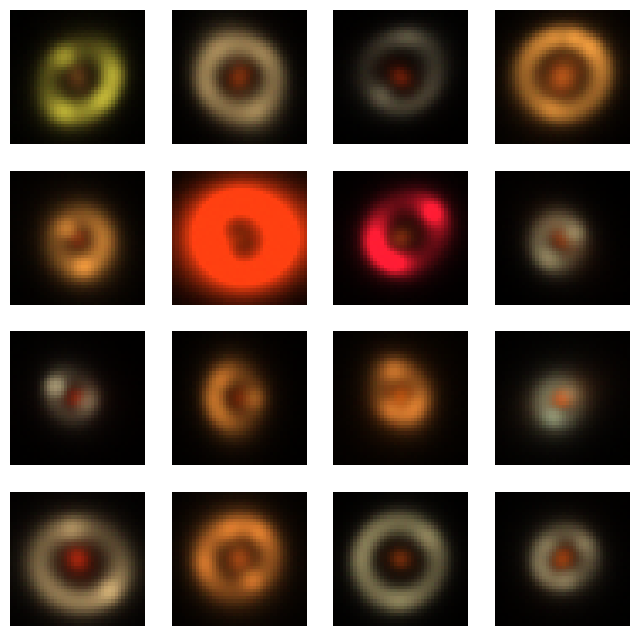

In [4]:
# Visualize source data
visualize_data(source_data)

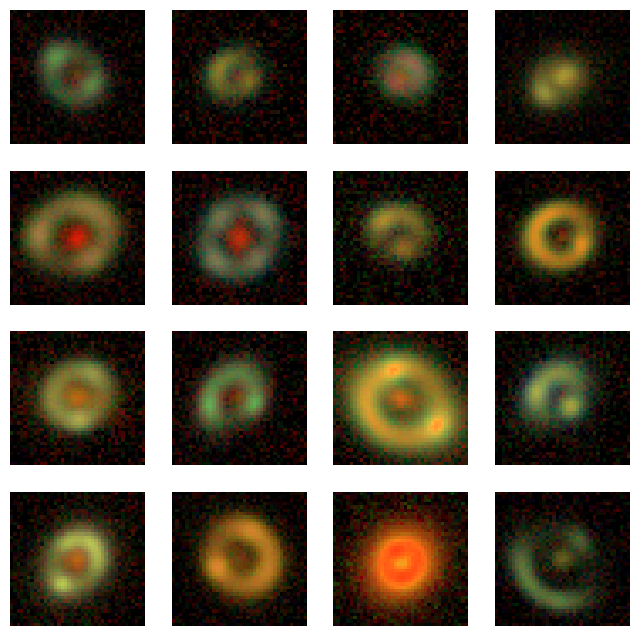

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

DA Weight is set according to MVE-Only or MVE-UDA run. Specifically,  
* MVE-UDA: DA Weight = constant 1.4
* MVE-only: DA Weight = constant 0.0, i.e. NO DA Loss

In [7]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    # else:
    #     da_weight = final_wt_da
    return 1.4

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    # if epoch < evolv_epoch:
    #     beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    # else:
    #     beta_val = beta_final
    return 0.5

# Initialize hyperparameters
n_epoch = 150


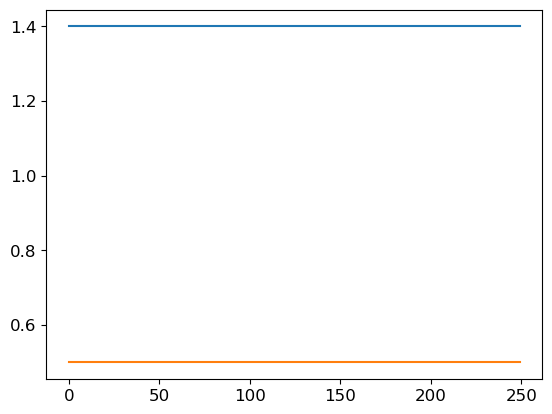

In [8]:
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

### Initialize the Model

Model architecture (MVEv3) is identical to architecture in the paper and summarized below.

In [9]:
# Initialize model
model = NeuralNetworkMVEv3(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.AdamW(model.parameters())

In [10]:
from torchsummary import summary
summary(model, (3, 40, 40))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

### Initialize Model State

If loading a paused run, enter a `load_mod_name`. If not, leave None, and the state will be initialized automatically.  
`save_mod_name` describes what root name models will be saved under during training.

In [11]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss, best_snll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/RunB"

## Train

Beginning Training...
Generating Isomap...


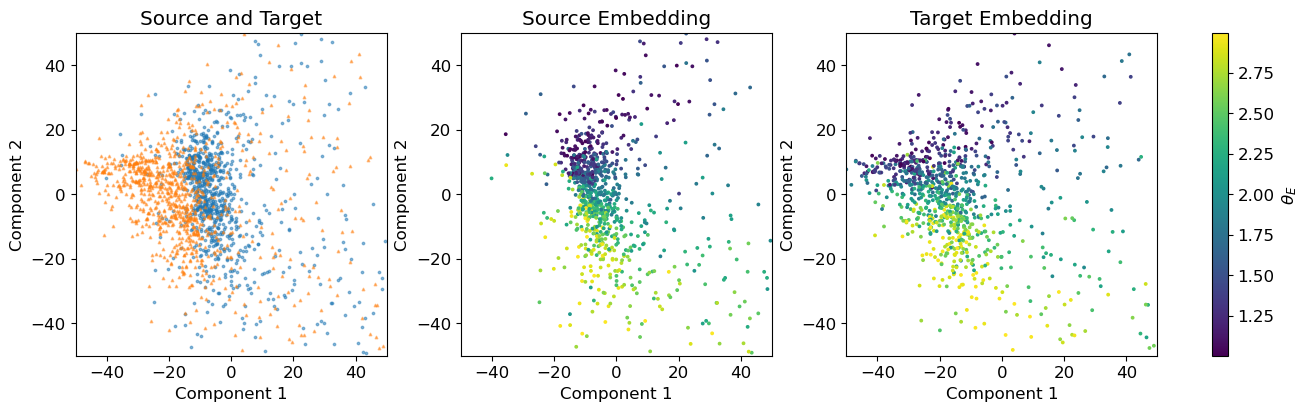

Saving Model... Done.

Epoch 0: 34.03s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0365
	Train Regression Loss: : 0.3124
	Train Mve Loss: : -0.0192
	Train R2 Score: : 0.0633
 Validation Statistics:
	Val Source Regression Loss: : 0.0132
	Val Target Regression Loss: : 0.0147
	Val Source R2 Score: : 0.9592
	Val Target R2 Score: : 0.9558
	Val Source Mve Loss: : -0.2406
	Val Target Mve Loss: : -0.2359
	Val Source Nll Loss: : -1.5918
	Val Target Nll Loss: : -1.5551
Saving Model... Done.
Saving Model MVE... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 1: 34.47s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0354
	Train Regression Loss: : 0.0224
	Train Mve Loss: : -0.2555
	Train R2 Score: : 0.9323
 Validation Statistics:
	Val Source Regression Loss: : 0.0189
	Val Target Regression Loss: : 0.0194
	Val Source R2 Score: : 0.9417
	Val Target R2 Score: : 0.9424
	Val Source Mve Loss: : -0.3026
	Val Target Mve Loss: : -0.30

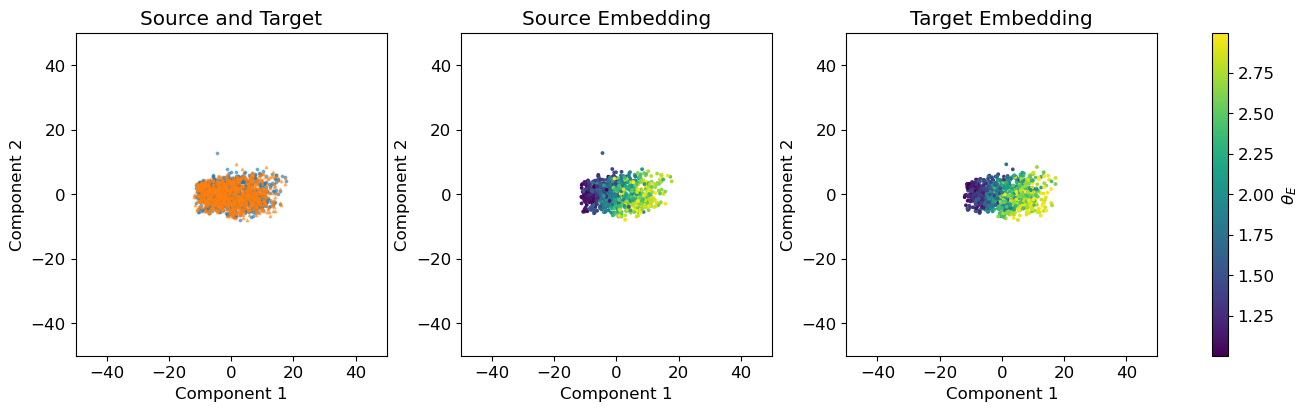

Saving Model... Done.

Epoch 20: 65.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0396
	Train Regression Loss: : 0.0033
	Train Mve Loss: : -0.1916
	Train R2 Score: : 0.9899
 Validation Statistics:
	Val Source Regression Loss: : 0.0027
	Val Target Regression Loss: : 0.0034
	Val Source R2 Score: : 0.9917
	Val Target R2 Score: : 0.9899
	Val Source Mve Loss: : -0.1435
	Val Target Mve Loss: : -0.1392
	Val Source Nll Loss: : -2.5184
	Val Target Nll Loss: : -2.4420
Saving Model... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 21: 72.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0398
	Train Regression Loss: : 0.0049
	Train Mve Loss: : -0.1804
	Train R2 Score: : 0.9853
 Validation Statistics:
	Val Source Regression Loss: : 0.0032
	Val Target Regression Loss: : 0.0038
	Val Source R2 Score: : 0.9901
	Val Target R2 Score: : 0.9887
	Val Source Mve Loss: : -0.1730
	Val Target Mve Loss: : -0.1702
	Val Source Nll Loss:

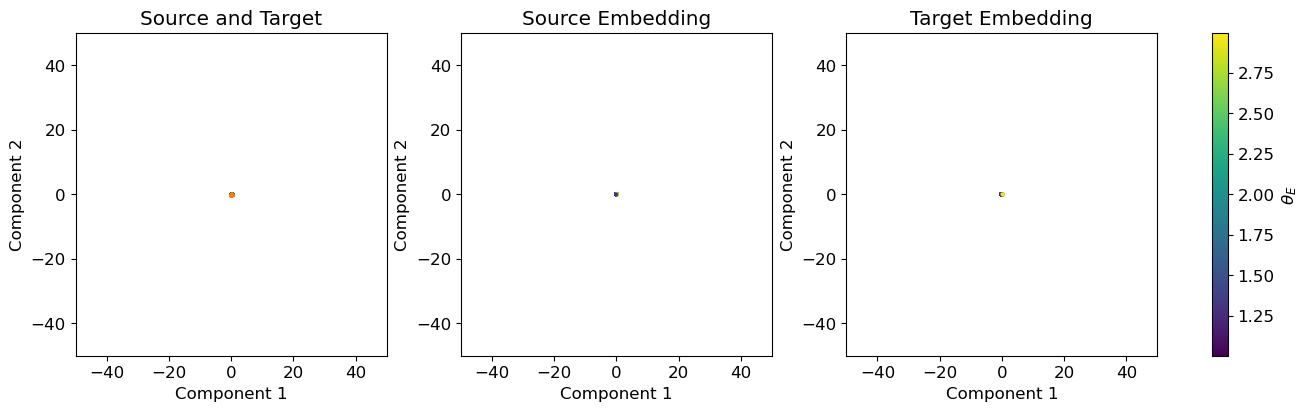

Saving Model... Done.

Epoch 40: 68.56s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0438
	Train Regression Loss: : 0.0051
	Train Mve Loss: : -0.1601
	Train R2 Score: : 0.9844
 Validation Statistics:
	Val Source Regression Loss: : 0.0034
	Val Target Regression Loss: : 0.0048
	Val Source R2 Score: : 0.9895
	Val Target R2 Score: : 0.9856
	Val Source Mve Loss: : -0.1583
	Val Target Mve Loss: : -0.1484
	Val Source Nll Loss: : -2.3167
	Val Target Nll Loss: : -2.1677

Epoch 41: 79.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0434
	Train Regression Loss: : 0.0053
	Train Mve Loss: : -0.1891
	Train R2 Score: : 0.9839
 Validation Statistics:
	Val Source Regression Loss: : 0.0050
	Val Target Regression Loss: : 0.0064
	Val Source R2 Score: : 0.9846
	Val Target R2 Score: : 0.9808
	Val Source Mve Loss: : -0.2441
	Val Target Mve Loss: : -0.2385
	Val Source Nll Loss: : -1.9005
	Val Target Nll Loss: : -1.8568

Epoch 42: 84.63s
--------------

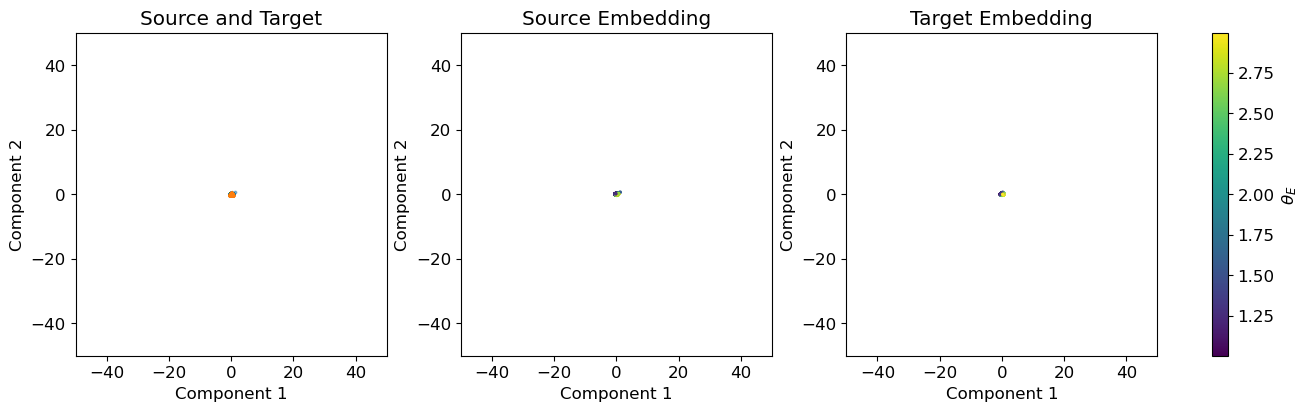

Saving Model... Done.

Epoch 60: 68.78s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0417
	Train Regression Loss: : 0.0203
	Train Mve Loss: : -0.3228
	Train R2 Score: : 0.9387
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.0134
	Val Source R2 Score: : 0.9650
	Val Target R2 Score: : 0.9603
	Val Source Mve Loss: : -0.3279
	Val Target Mve Loss: : -0.3241
	Val Source Nll Loss: : -1.2616
	Val Target Nll Loss: : -1.2471

Epoch 61: 94.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0437
	Train Regression Loss: : 0.0089
	Train Mve Loss: : -0.2021
	Train R2 Score: : 0.9731
 Validation Statistics:
	Val Source Regression Loss: : 0.0074
	Val Target Regression Loss: : 0.0095
	Val Source R2 Score: : 0.9773
	Val Target R2 Score: : 0.9718
	Val Source Mve Loss: : -0.1435
	Val Target Mve Loss: : -0.1294
	Val Source Nll Loss: : -1.8965
	Val Target Nll Loss: : -1.6984

Epoch 62: 64.53s
--------------

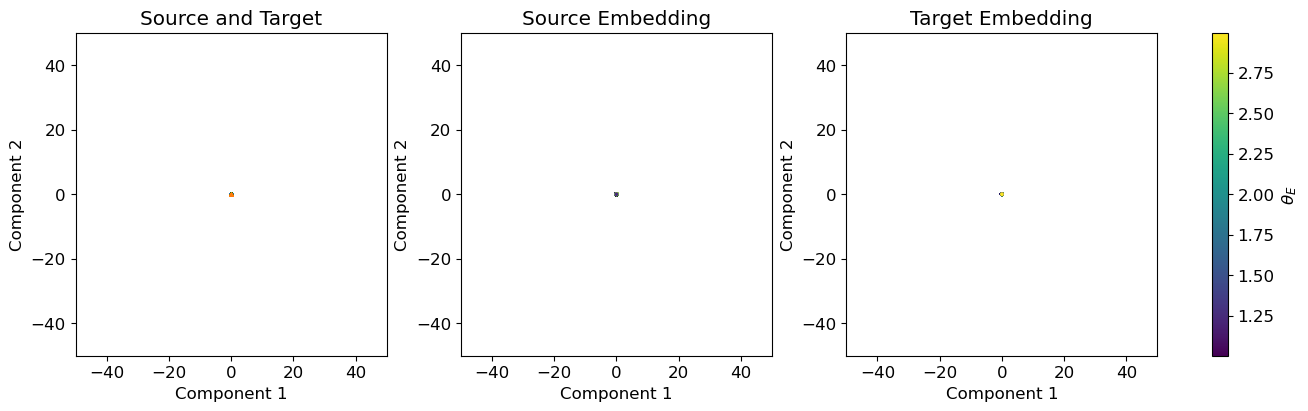

Saving Model... Done.

Epoch 80: 70.60s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0424
	Train Regression Loss: : 0.0096
	Train Mve Loss: : -0.3448
	Train R2 Score: : 0.9711
 Validation Statistics:
	Val Source Regression Loss: : 0.0055
	Val Target Regression Loss: : 0.0073
	Val Source R2 Score: : 0.9831
	Val Target R2 Score: : 0.9783
	Val Source Mve Loss: : -0.3197
	Val Target Mve Loss: : -0.3155
	Val Source Nll Loss: : -1.4625
	Val Target Nll Loss: : -1.4439

Epoch 81: 81.25s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0432
	Train Regression Loss: : 0.0071
	Train Mve Loss: : -0.1996
	Train R2 Score: : 0.9784
 Validation Statistics:
	Val Source Regression Loss: : 0.0143
	Val Target Regression Loss: : 0.0162
	Val Source R2 Score: : 0.9563
	Val Target R2 Score: : 0.9517
	Val Source Mve Loss: : -0.1285
	Val Target Mve Loss: : -0.1174
	Val Source Nll Loss: : -1.5503
	Val Target Nll Loss: : -1.4197

Epoch 82: 79.53s
--------------

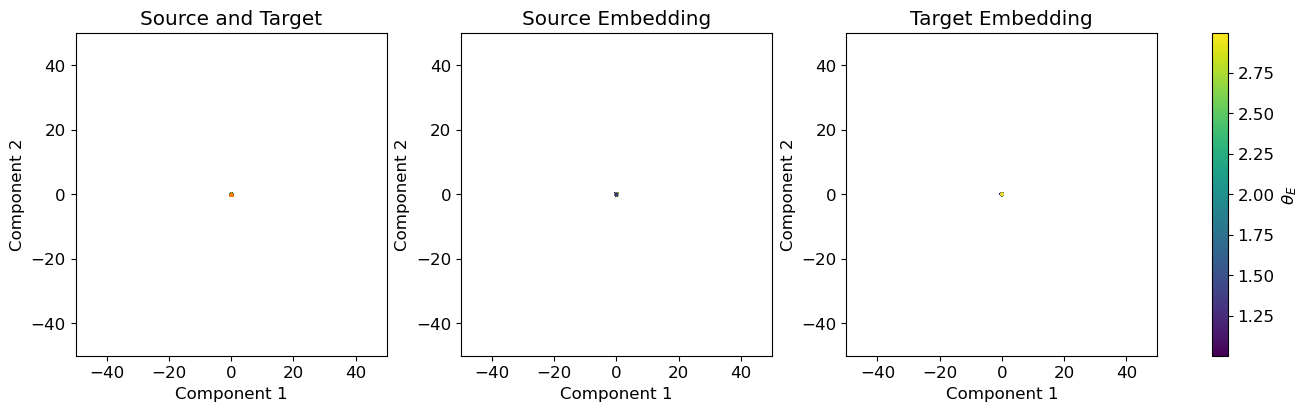

Saving Model... Done.

Epoch 100: 70.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0440
	Train Regression Loss: : 0.0086
	Train Mve Loss: : -0.1767
	Train R2 Score: : 0.9741
 Validation Statistics:
	Val Source Regression Loss: : 0.0086
	Val Target Regression Loss: : 0.0095
	Val Source R2 Score: : 0.9736
	Val Target R2 Score: : 0.9718
	Val Source Mve Loss: : -0.1629
	Val Target Mve Loss: : -0.1579
	Val Source Nll Loss: : -1.8742
	Val Target Nll Loss: : -1.8161

Epoch 101: 75.30s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0435
	Train Regression Loss: : 0.0079
	Train Mve Loss: : -0.1715
	Train R2 Score: : 0.9760
 Validation Statistics:
	Val Source Regression Loss: : 0.0076
	Val Target Regression Loss: : 0.0081
	Val Source R2 Score: : 0.9765
	Val Target R2 Score: : 0.9757
	Val Source Mve Loss: : -0.1981
	Val Target Mve Loss: : -0.1961
	Val Source Nll Loss: : -1.9086
	Val Target Nll Loss: : -1.8916

Epoch 102: 68.70s
-----------

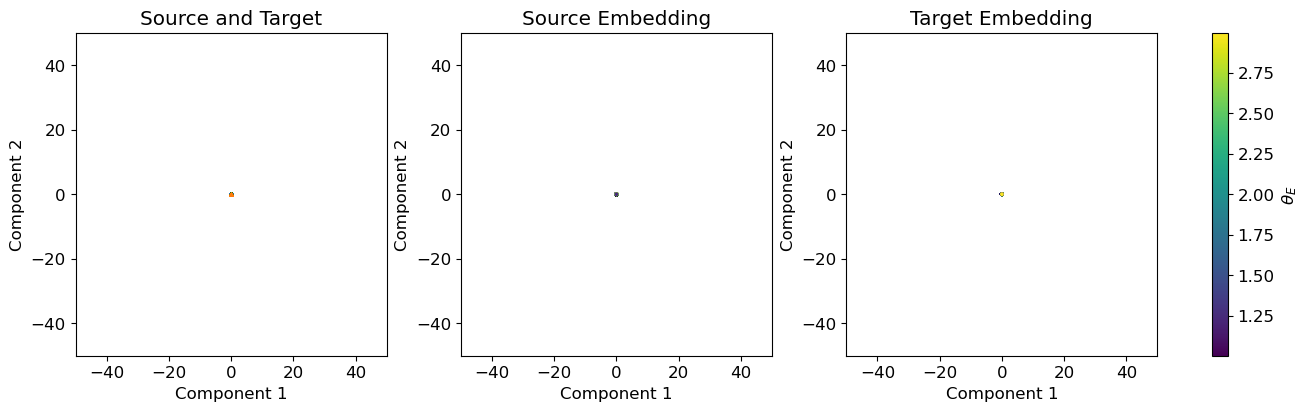

Saving Model... Done.

Epoch 120: 67.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0437
	Train Regression Loss: : 0.0052
	Train Mve Loss: : -0.1587
	Train R2 Score: : 0.9843
 Validation Statistics:
	Val Source Regression Loss: : 0.0044
	Val Target Regression Loss: : 0.0058
	Val Source R2 Score: : 0.9865
	Val Target R2 Score: : 0.9828
	Val Source Mve Loss: : -0.1671
	Val Target Mve Loss: : -0.1579
	Val Source Nll Loss: : -2.1948
	Val Target Nll Loss: : -2.0742

Epoch 121: 75.94s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0429
	Train Regression Loss: : 0.0056
	Train Mve Loss: : -0.1651
	Train R2 Score: : 0.9829
 Validation Statistics:
	Val Source Regression Loss: : 0.0052
	Val Target Regression Loss: : 0.0070
	Val Source R2 Score: : 0.9839
	Val Target R2 Score: : 0.9793
	Val Source Mve Loss: : -0.2022
	Val Target Mve Loss: : -0.1934
	Val Source Nll Loss: : -2.0479
	Val Target Nll Loss: : -1.9584

Epoch 122: 75.82s
-----------

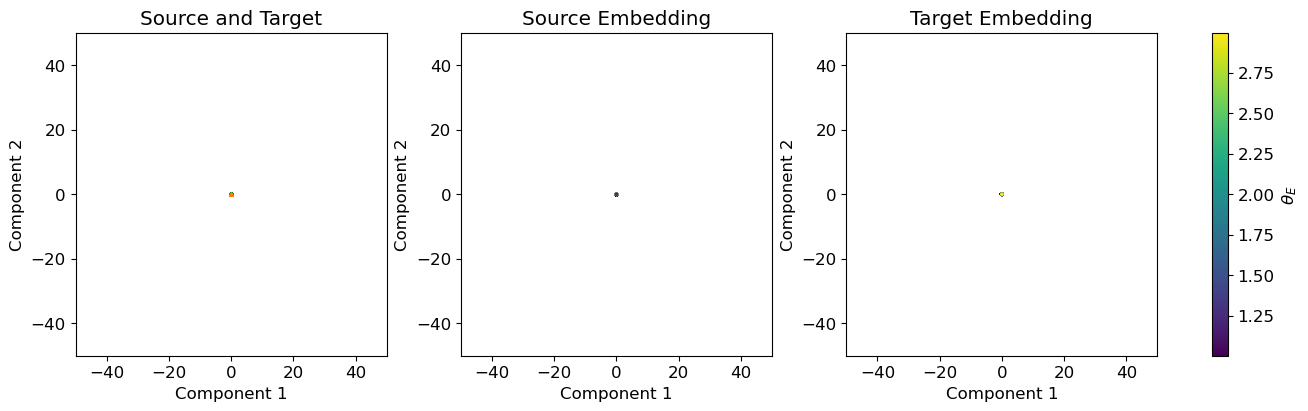

Saving Model... Done.

Epoch 140: 80.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0421
	Train Regression Loss: : 0.0049
	Train Mve Loss: : -0.1785
	Train R2 Score: : 0.9852
 Validation Statistics:
	Val Source Regression Loss: : 0.0055
	Val Target Regression Loss: : 0.0075
	Val Source R2 Score: : 0.9831
	Val Target R2 Score: : 0.9778
	Val Source Mve Loss: : -0.1548
	Val Target Mve Loss: : -0.1414
	Val Source Nll Loss: : -2.1000
	Val Target Nll Loss: : -1.9185

Epoch 141: 91.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0437
	Train Regression Loss: : 0.0210
	Train Mve Loss: : -0.1908
	Train R2 Score: : 0.9360
 Validation Statistics:
	Val Source Regression Loss: : 0.0194
	Val Target Regression Loss: : 0.0222
	Val Source R2 Score: : 0.9402
	Val Target R2 Score: : 0.9342
	Val Source Mve Loss: : -0.3078
	Val Target Mve Loss: : -0.3054
	Val Source Nll Loss: : -0.5510
	Val Target Nll Loss: : -0.5466

Epoch 142: 64.94s
-----------

In [12]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)
            
            print("Saving Model...", end = ' ')
            save_model(save_mod_name + "_{}".format(curr_epoch), model, optimizer, stats)
            print("Done.")

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_source_nll_loss'][-1] < best_snll_loss):
                print("Saving Model SNLL...", end = ' ')
                snll_name = save_mod_name + "_snll"
                save_model(snll_name, model, optimizer, stats)
                best_snll_loss = stats['val_source_nll_loss'][-1]
                print("Done.")
        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)


        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [13]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

You can visualize the results below. We recommend using the `VisualizeModel.ipynb` notebook for more detailed visualization.

In [ ]:
# Loads a model for plotting/viz

viz_mod_name = save_mod_name#"models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [ ]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

In [ ]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 1)

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [ ]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [ ]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [ ]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()